In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression




In [7]:
df=pd.read_csv('spotify_millsongdata.csv')

In [8]:
df.loc[0,'text']

"Look at her face, it's a wonderful face  \r\nAnd it means something special to me  \r\nLook at the way that she smiles when she sees me  \r\nHow lucky can one fellow be?  \r\n  \r\nShe's just my kind of girl, she makes me feel fine  \r\nWho could ever believe that she could be mine?  \r\nShe's just my kind of girl, without her I'm blue  \r\nAnd if she ever leaves me what could I do, what could I do?  \r\n  \r\nAnd when we go for a walk in the park  \r\nAnd she holds me and squeezes my hand  \r\nWe'll go on walking for hours and talking  \r\nAbout all the things that we plan  \r\n  \r\nShe's just my kind of girl, she makes me feel fine  \r\nWho could ever believe that she could be mine?  \r\nShe's just my kind of girl, without her I'm blue  \r\nAnd if she ever leaves me what could I do, what could I do?\r\n\r\n"

In [9]:
df.shape

(57650, 4)

In [10]:
df=df.sample(25000).drop('link', axis=1).reset_index(drop=True)


In [11]:
pp=df.copy()

In [12]:
pp['text'] = pp['text'].apply(lambda x: str(x).lower().replace(r'^\w\s',' ').replace(r'\n',' ',))

In [13]:
df['text']= df['text'].apply(lambda x :str(x).replace(r'\n\r',' '))

NOW that we have assigned the link to another column we can drop them


In [14]:
df.shape

(25000, 3)

In [15]:
artist_list=df.groupby('artist').count()

Now we are having 643 artist list in our dataset


In [16]:
artist_list.count()

song    638
text    638
dtype: int64

In [17]:
df['song']=df['song'].str.lower()

In [18]:
df['text'].str.count('\n').sum()

1029380

In [19]:
df.columns

Index(['artist', 'song', 'text'], dtype='object')

In [20]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer


In [21]:

# import nltk
# it is a nlp library , it is used to process the text data
# from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
# stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KUSHAL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In this the similar words which are having same meaning but differ in spelling are changed into one common word


In [22]:
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenization and lowercase conversion
    tokens = [token for token in tokens if token not in stop_words and token not in punctuation]  # Stopword and punctuation removal
    
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)
     

In [23]:
# # import nltk
# # nltk.download('punkt')
# token(df['text'][0])
# token('hello world beautiful beauty')

In [24]:
df['cleaned text']=df['text'].apply(preprocess_text)


In [25]:
tdidf=TfidfVectorizer(analyzer='word', stop_words='english')
metrixs=tdidf.fit_transform(df['cleaned text'])

Here we are taking sample data for testing 


In [26]:
# from sklearn.metrics.pairwise import cosine_similarity
# from scipy.sparse import csr_matrix

# # Assuming 'matrix' is a sparse matrix in CSR format
# sparse_matrix = csr_matrix(matrix)

# # Compute cosine similarity using sparse matrices
similar = cosine_similarity(metrixs)

In [27]:
similar[0]

array([1.        , 0.00284703, 0.01305363, ..., 0.03294094, 0.        ,
       0.01009582])

In [28]:
df['song']

0                my funny valentine
1                      freak magnet
2                         soul kiss
3             state of independence
4                          rich kid
                    ...            
24995                   dawntreader
24996            frankie and johnny
24997               love like a man
24998    2000 light years from home
24999             i felt the luxury
Name: song, Length: 25000, dtype: object

In [29]:
# df[df['song']=="city's burning"].index[0]

Now we are making recommder function for getting the songs


In [30]:
def recommder(song_name):
    idx=df[df['song']==song_name].index[0]
    distance=sorted(list(enumerate(similar[idx])), key=lambda x: x[1], reverse=True)
    song=[]
    for s_id in distance[1:20]:
        song.append(df.iloc[s_id[0]].song)
    return song
    
    

In [31]:
# recommder("steel drivin' man")

In [32]:
print(pp.iloc[0].text)

[verse 1]  
my funny valentine  
sweet comic valentine  
you make me smile with my heart  
your looks are laughable  
unphotographable  
yet your my favourite work of art  
  
[bridge]  
is your figure less than greek?  
is your mouth a little weak?  
when you open it to speak  
are you smart?  
  
[chorus]  
but don't change your hair for me  
not if you care for me  
stay little valentine, stay  
each day is valentine's day




Now we are gonna do the dumping of our code to bytes through pickle with dump method

In [33]:
def artist_songs(song_name):
    index_range=pp[pp['song']==song_name].artist
    artist_list=pp[pp['artist']==index_range.iloc[0]].song
    return artist_list

In [34]:

from sklearn.datasets import make_blobs
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [35]:
# del sampled_descriptions

In [36]:
sampled_descriptions = df

now we are going to take the sample data

In [37]:
# # Randomly sample a subset of song descriptions for clustering (adjust sample size as needed)
# sample_size = 1000
# random_indices = np.random.choice(len(df['cleaned text']), size=sample_size, replace=False)
# sampled_descriptions = [df.iloc[i] for i in random_indices]

In [38]:
sampled_descriptions=pd.DataFrame(sampled_descriptions)

we need to change it to data frame

now that we got the sampled data , we gonna do tfidf on that sampled data


In [39]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
tdif=TfidfVectorizer(analyzer='word', stop_words='english', max_features=100)

In [40]:
matrix=tdif.fit_transform(sampled_descriptions['cleaned text'])

In [41]:
print(matrix.shape)

(25000, 100)


In [42]:
# del wcss
# del silhouette_scores

In [43]:
wcss = []
silhouette_scores = []

# Try different values of k (number of clusters) and compute WCSS and silhouette scores
for k in range(2, 25):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)
    wcss.append(kmeans.inertia_)  # Within-cluster sum of squares
    silhouette_scores.append(silhouette_score(matrix, kmeans.labels_))
    

C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The defaul

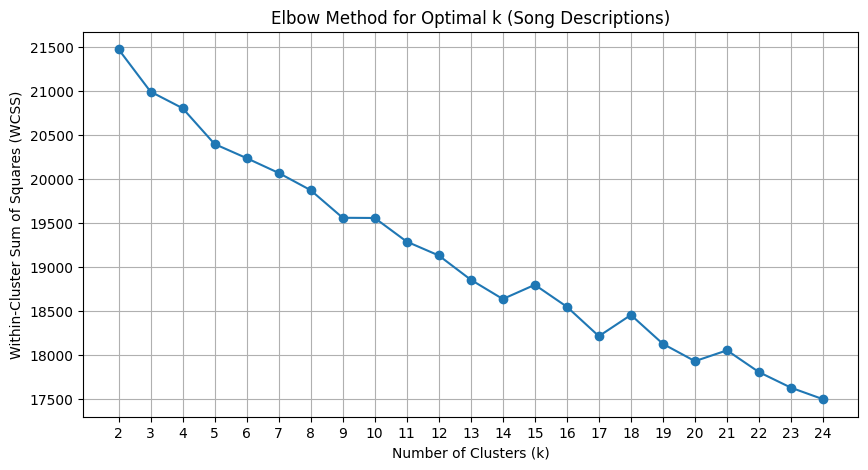

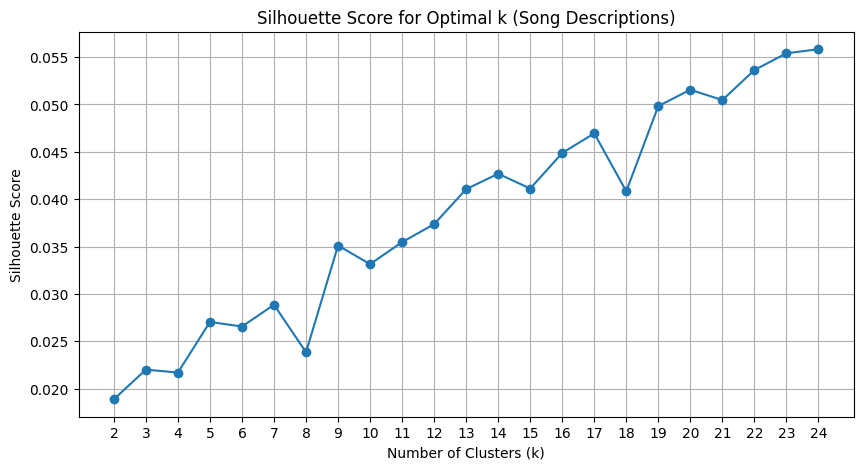

In [44]:
# Plotting Elbow Method (WCSS vs. Number of Clusters)
plt.figure(figsize=(10, 5))
plt.plot(range(2, 25), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k (Song Descriptions)')
plt.xticks(np.arange(2, 25))
plt.grid(True)
plt.show()

# Plotting Silhouette Score vs. Number of Clusters
plt.figure(figsize=(10, 5))
plt.plot(range(2, 25), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k (Song Descriptions)')
plt.xticks(np.arange(2, 25))
plt.grid(True)
plt.show()

In [45]:

from sklearn.decomposition import TruncatedSVD

Initialize MiniBatchKMeans clustering with optimal k (e.g., based on elbow method or silhouette score)

C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


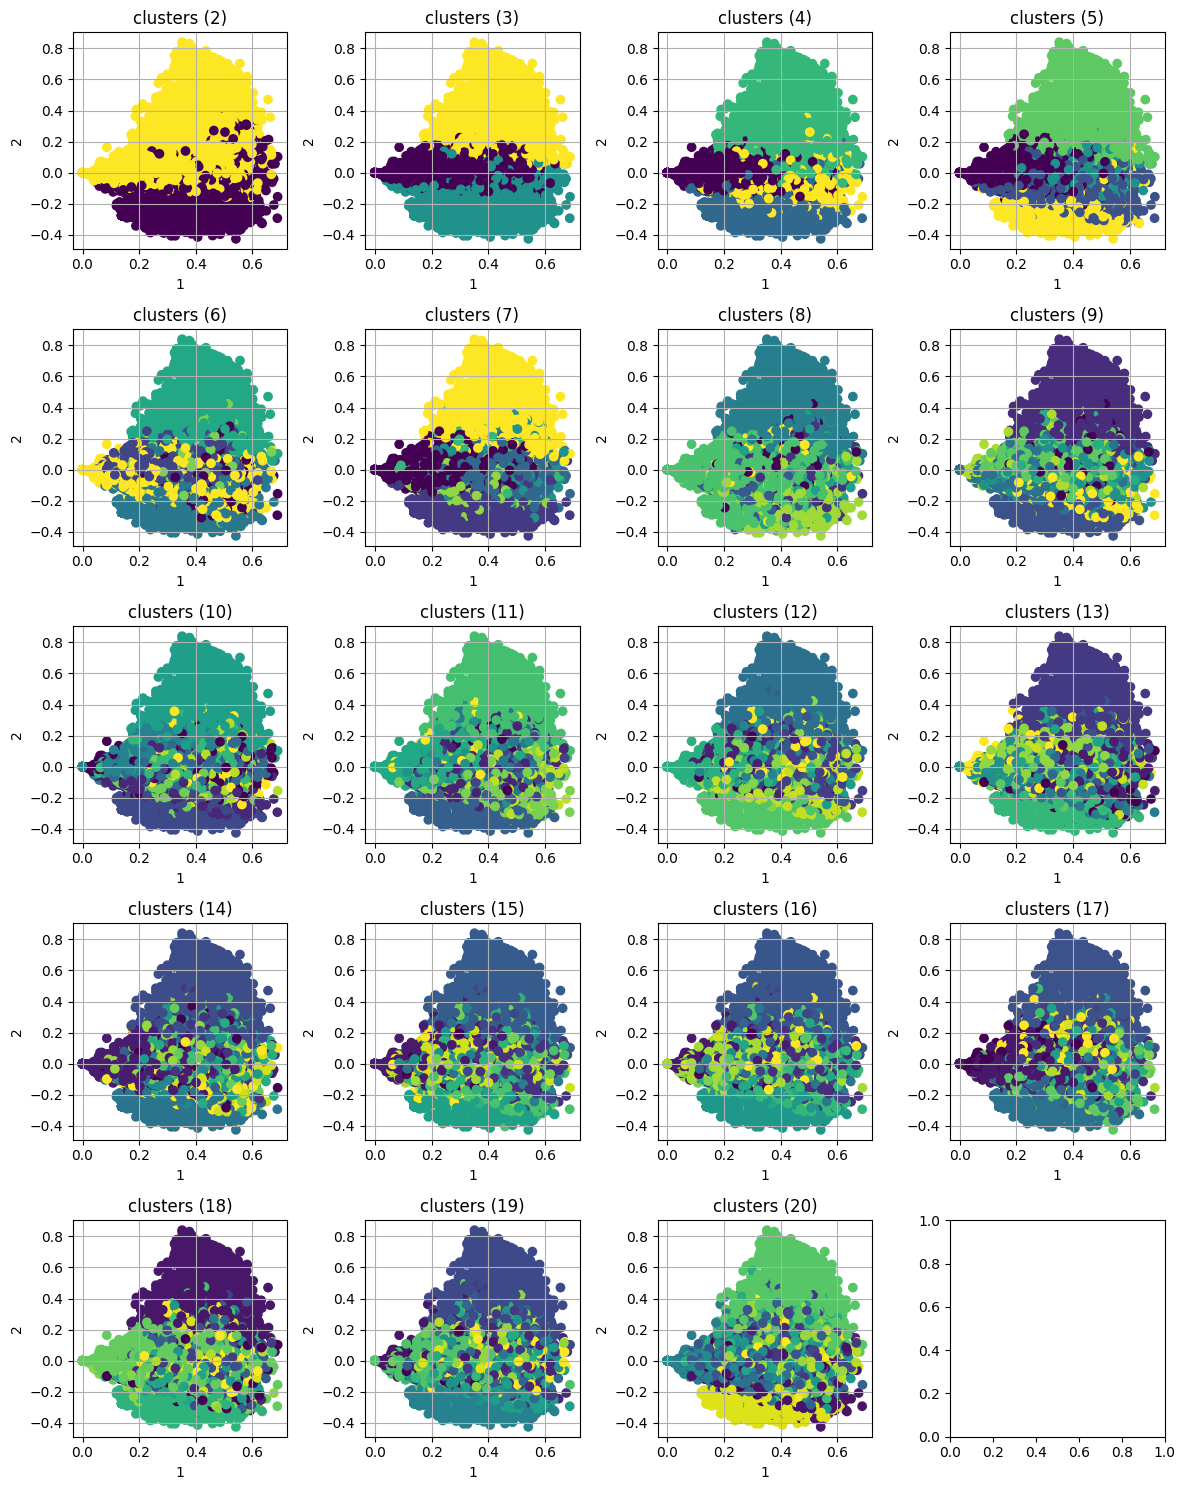

In [46]:
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import MiniBatchKMeans

# Assuming 'matrix' and 'tfidf_svd' are defined earlier in your code

svd = TruncatedSVD(n_components=2, random_state=0)
tfidf_svd = svd.fit_transform(matrix)

fig, axs = plt.subplots(5, 4)
fig.set_size_inches(12, 15)

scatter_plots = []

# Initialize MiniBatchKMeans clustering with optimal k
for i in range(2, min(21, 5*4 + 2)):  # Adjust the range
    k = i
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0)
    kmeans.fit(matrix)

    # Get cluster labels and plot clusters in a scatter plot
    cluster_labels = kmeans.labels_
    scatter_plot = axs[int((i - 2) / 4), (i - 2) % 4].scatter(tfidf_svd[:, 0], tfidf_svd[:, 1], c=cluster_labels, cmap='viridis')

    axs[int((i - 2) / 4), (i - 2) % 4].set_xlabel('1')
    axs[int((i - 2) / 4), (i - 2) % 4].set_ylabel('2')
    axs[int((i - 2) / 4), (i - 2) % 4].set_title(f'clusters ({k})')
    axs[int((i - 2) / 4), (i - 2) % 4].grid(True)

    scatter_plots.append(scatter_plot)  # Add scatter plot object to the list

# Add colorbar
# fig.colorbar(scatter_plots[-1], ax=axs.ravel().tolist(), location='left', pad=0.05, label='Cluster')

plt.tight_layout()
plt.show()


In [47]:
kmeans = KMeans(n_clusters=18, init='k-means++', random_state=42)
kmeans.fit(matrix)

# Add cluster labels to dataset
sampled_descriptions['cluster'] = kmeans.labels_+2


C:\Users\KUSHAL\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [48]:
set(kmeans.labels_)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

In [49]:
kmeans.cluster_centers_.shape

(18, 100)

In [50]:
import pickle

In [51]:
# pickle.dump(similar, open('similar.pkl', 'wb'))

In [52]:
# pickle.dump(df, open('df.pkl', 'wb'))

In [53]:

# Dictionary for genre values (with values converted to strings)
genre_values = {
    'Classical': ['Orchestral, Symphonic, Compositional complexity, Instrumental mastery, Elegance, '
                 'Formal structure, Timelessness, Emotionally evocative, Virtuosity'],
    'Heavy Metal': ['Aggression, Distortion, Amplification, Dark themes, Intensity, Rebellion, '
                   'Complex guitar riffs, Screaming vocals, Power'],
    'Punk': ['Anarchy, Rebellion, DIY ethos, Raw energy, Fast tempo, Anti-establishment, '
            'Political dissent, Social commentary, Minimalism'],
    'Reggaeton': ['Rhythm, Danceability, Spanish lyrics, Latin beats, Urban culture, Sensuality, '
                 'Party atmosphere, Caribbean influence, Fusion of genres'],
    'Indie': ['Alternative, DIY spirit, Non-conformity, Quirkiness, Artistic expression, Subculture, '
             'Introspection, Authenticity, Underground'],
    'Gospel': ['Faith, Spirituality, Worship, Soulful vocals, Joy, Testimony, Redemption, Church, '
              'Hope'],
    'Metalcore': ['Aggression, Breakdowns, Screamed vocals, Melodic elements, Technical proficiency, '
                 'Emotional intensity, Dual vocal styles, Heavy guitar riffing, Catharsis'],
    'Ska': ['Upbeat tempo, Offbeat rhythm, Horn sections, Jamaican influence, Danceable grooves, Fun, '
           'Lightheartedness, Subcultural identity, Skanking'],
    'Funk': ['Groove, Rhythmic syncopation, Soulful vocals, Danceability, Improvisation, '
            'Tight instrumentation, Syncopated basslines, Horn sections, Party atmosphere'],
    'Disco': ['Dancefloor, Glittering, Funky basslines, Four-on-the-floor beat, Studio production, '
             'High energy, Glamour, Nightlife, Liberation'],
    'Country': ['Rural themes, Simple melodies, Acoustic instruments, Storytelling, '
                'Western influences, Folk traditions, Heartache, Americana, Honesty'],
    'Hip Hop': ['Rap, Beats, Urban culture, Street life, DJ scratching, Sampling, '
                'Rhyme, Flow, Authenticity'],
    'Jazz': ['Improvisation, Swing, Syncopation, Blue notes, Instrumental virtuosity, '
             'Big band, Coolness, Soulfulness, Experimentalism'],
    'Rock': ['Guitars, Rebellion, Power chords, Amplification, Youth culture, '
             'Verses and choruses, Expressiveness, Energy, Attitude'],
    'Electronic': ['Synthesizers, Beats, Sampling, Dancefloor, Futurism, '
                   'Soundscapes, Repetition, Technological innovation, Experimentation'],
    'Blues': ['12-bar structure, Call and response, Soulful vocals, Guitar solos, '
              'Lament, Struggle, Improvisation, Feeling, Authenticity'],
    'R&B': ['Rhythm and blues, Soul, Groove, Sensuality, Vocals, Love themes, '
            'Influential artists, Heartfelt lyrics, Melodic hooks'],
    'Pop': ['Catchy melodies, Hooks, Commercial appeal, Studio production, '
            'Youth culture, Upbeat tempo, Sing-along choruses, Mainstream appeal, Radio-friendly'],
    'Alternative': ['Non-mainstream, Innovation, Diversity, Independent spirit, '
                     'Experimentalism, Subversion, Eclecticism, Counterculture'],
    'World': ['Cultural diversity, Traditional instruments, Ethnic rhythms, '
              'Global fusion, Folklore, International influences, Exoticism, Celebration']
}

# Dictionary for genre labels
genre_labels = {
    'Classical': 0,
    'Heavy Metal': 1,
    'Punk': 2,
    'Reggaeton': 3,
    'Indie': 4,
    'Gospel': 5,
    'Metalcore': 6,
    'Ska': 7,
    'Funk': 8,
    'Disco': 9,
    'Country': 10,
    'Hip Hop': 11,
    'Jazz': 12,
    'Rock': 13,
    'Electronic': 14,
    'Blues': 15,
    'R&B': 16,
    'Pop': 17,
    'Alternative': 18,
    'World': 19
}

genre_themes = {
    'Classical': 'Orchestral, Symphonic, Compositional complexity, Instrumental mastery, Elegance, '
                 'Formal structure, Timelessness, Emotionally evocative, Virtuosity',
    'Heavy Metal': 'Aggression, Distortion, Amplification, Dark themes, Intensity, Rebellion, '
                   'Complex guitar riffs, Screaming vocals, Power',
    'Punk': 'Anarchy, Rebellion, DIY ethos, Raw energy, Fast tempo, Anti-establishment, '
            'Political dissent, Social commentary, Minimalism',
    'Reggaeton': 'Rhythm, Danceability, Spanish lyrics, Latin beats, Urban culture, Sensuality, '
                 'Party atmosphere, Caribbean influence, Fusion of genres',
    'Indie': 'Alternative, DIY spirit, Non-conformity, Quirkiness, Artistic expression, Subculture, '
             'Introspection, Authenticity, Underground',
    'Gospel': 'Faith, Spirituality, Worship, Soulful vocals, Joy, Testimony, Redemption, Church, '
              'Hope',
    'Metalcore': 'Aggression, Breakdowns, Screamed vocals, Melodic elements, Technical proficiency, '
                 'Emotional intensity, Dual vocal styles, Heavy guitar riffing, Catharsis',
    'Ska': 'Upbeat tempo, Offbeat rhythm, Horn sections, Jamaican influence, Danceable grooves, Fun, '
           'Lightheartedness, Subcultural identity, Skanking',
    'Funk': 'Groove, Rhythmic syncopation, Soulful vocals, Danceability, Improvisation, '
            'Tight instrumentation, Syncopated basslines, Horn sections, Party atmosphere',
    'Disco': 'Dancefloor, Glittering, Funky basslines, Four-on-the-floor beat, Studio production, '
             'High energy, Glamour, Nightlife, Liberation',
    'Country': 'Rural themes, Simple melodies, Acoustic instruments, Storytelling, '
                'Western influences, Folk traditions, Heartache, Americana, Honesty',
    'Hip Hop': 'Rap, Beats, Urban culture, Street life, DJ scratching, Sampling, '
                'Rhyme, Flow, Authenticity',
    'Jazz': 'Improvisation, Swing, Syncopation, Blue notes, Instrumental virtuosity, '
             'Big band, Coolness, Soulfulness, Experimentalism',
    'Rock': 'Guitars, Rebellion, Power chords, Amplification, Youth culture, '
}

In [54]:
kmeans.labels_.shape

(25000,)

In [55]:
genre_values

{'Classical': ['Orchestral, Symphonic, Compositional complexity, Instrumental mastery, Elegance, Formal structure, Timelessness, Emotionally evocative, Virtuosity'],
 'Heavy Metal': ['Aggression, Distortion, Amplification, Dark themes, Intensity, Rebellion, Complex guitar riffs, Screaming vocals, Power'],
 'Punk': ['Anarchy, Rebellion, DIY ethos, Raw energy, Fast tempo, Anti-establishment, Political dissent, Social commentary, Minimalism'],
 'Reggaeton': ['Rhythm, Danceability, Spanish lyrics, Latin beats, Urban culture, Sensuality, Party atmosphere, Caribbean influence, Fusion of genres'],
 'Indie': ['Alternative, DIY spirit, Non-conformity, Quirkiness, Artistic expression, Subculture, Introspection, Authenticity, Underground'],
 'Gospel': ['Faith, Spirituality, Worship, Soulful vocals, Joy, Testimony, Redemption, Church, Hope'],
 'Metalcore': ['Aggression, Breakdowns, Screamed vocals, Melodic elements, Technical proficiency, Emotional intensity, Dual vocal styles, Heavy guitar riffin

In [56]:
genre_description_list = []

for genre, description_list in genre_values.items():
    for description in description_list:
        genre_description_list.append({'Genre': genre, 'Description': description})

genre_data = pd.DataFrame(genre_description_list)

genre_data

,Genre,Description
0,Classical,"Orchestral, Symphonic, Compositional complexit..."
1,Heavy Metal,"Aggression, Distortion, Amplification, Dark th..."
2,Punk,"Anarchy, Rebellion, DIY ethos, Raw energy, Fas..."
3,Reggaeton,"Rhythm, Danceability, Spanish lyrics, Latin be..."
4,Indie,"Alternative, DIY spirit, Non-conformity, Quirk..."
5,Gospel,"Faith, Spirituality, Worship, Soulful vocals, ..."
6,Metalcore,"Aggression, Breakdowns, Screamed vocals, Melod..."
7,Ska,"Upbeat tempo, Offbeat rhythm, Horn sections, J..."
8,Funk,"Groove, Rhythmic syncopation, Soulful vocals, ..."
9,Disco,"Dancefloor, Glittering, Funky basslines, Four-..."


In [57]:
# del genre

In [58]:
genre_tfidf_matrix =tdif.fit_transform(genre_themes.values())
cluster_descriptions = tdif.transform(sampled_descriptions['cleaned text']) 
cluster_centroids = kmeans.cluster_centers_  
print(cluster_centroids.shape,genre_tfidf_matrix.shape)

(18, 100) (14, 100)


In [59]:
similarities = cosine_similarity(cluster_centroids, genre_tfidf_matrix)
similarities

array([[0.12767452, 0.15867267, 0.15672426, 0.12925944, 0.10383092,
        0.10607177, 0.13202501, 0.11937236, 0.13643221, 0.07169131,
        0.1131459 , 0.40080669, 0.0969016 , 0.16203234],
       [0.19326068, 0.39532725, 0.24724805, 0.17049658, 0.16997   ,
        0.15716722, 0.16785365, 0.17056274, 0.17842929, 0.08314377,
        0.1657517 , 0.16765769, 0.15967242, 0.5400539 ],
       [0.13054865, 0.35006008, 0.36579573, 0.13632626, 0.12001628,
        0.11557691, 0.13374415, 0.12643827, 0.13741047, 0.08627645,
        0.11250856, 0.11926414, 0.11922145, 0.52040918],
       [0.21233931, 0.21156029, 0.22316913, 0.19377779, 0.16285279,
        0.16912407, 0.17638072, 0.19586804, 0.1904972 , 0.10618147,
        0.15483581, 0.17785914, 0.4304547 , 0.20567005],
       [0.13758312, 0.14421213, 0.28488015, 0.11806029, 0.12470477,
        0.1088832 , 0.12322107, 0.1249184 , 0.41836777, 0.22945182,
        0.11149117, 0.12613488, 0.11158623, 0.15946963],
       [0.1462797 , 0.17769437, 0.1

In [60]:
cluster_genre_labels = {}
for i, cluster_similarities in enumerate(similarities):
    most_similar_genre_index = cluster_similarities.argmax()
    cluster_genre_labels[i] = genre_data.loc[most_similar_genre_index, 'Genre']

# Add genre labels to dataset
# data['genre'] = [cluster_genre_labels[cluster] for cluster in kmeans.labels_]

In [61]:
cluster_genre_labels

{0: 'Hip Hop',
 1: 'Rock',
 2: 'Rock',
 3: 'Jazz',
 4: 'Funk',
 5: 'Ska',
 6: 'Disco',
 7: 'Gospel',
 8: 'Hip Hop',
 9: 'Classical',
 10: 'Country',
 11: 'Heavy Metal',
 12: 'Indie',
 13: 'Reggaeton',
 14: 'Disco',
 15: 'Classical',
 16: 'Rock',
 17: 'Funk'}

In [62]:
sampled_descriptions['cluster']=[cluster_genre_labels[cluster] for cluster in kmeans.labels_]

In [63]:
sampled_descriptions


,artist,song,text,cleaned text,cluster
0,Sam Smith,my funny valentine,[Verse 1] \r\nMy funny valentine \r\nSweet c...,Verse 1 My funny valentine Sweet comic valenti...,Disco
1,Violent Femmes,freak magnet,Some magnets attract \r\nSome magnets repel ...,Some magnet attract Some magnet repel Some mag...,Rock
2,Olivia Newton-John,soul kiss,Soul kiss \r\nYou left me dreaming \r\nNow I...,Soul kiss You left dreaming Now I wonder thing...,Rock
3,Vangelis,state of independence,"State of life, may I live? May I love? \r\nCo...",State life may I live May I love Coming sky I ...,Ska
4,Uriah Heep,rich kid,She's a rich kid \r\nShe wears diamond rings ...,She 's rich kid She wear diamond ring Knows wa...,Rock
...,...,...,...,...,...
24995,Joni Mitchell,dawntreader,Peridots and periwinkle blue medallions \r\nG...,Peridots periwinkle blue medallion Gilded gall...,Classical
24996,Elvis Presley,frankie and johnny,Frankie and me we were lovers \r\nOh Lordy ho...,Frankie lover Oh Lordy could love Swore 'd tru...,Hip Hop
24997,Ten Years After,love like a man,You roly-poly \r\nAll over town \r\nBut you ...,You roly-poly All town But come back When thin...,Rock
24998,Rolling Stones,2000 light years from home,Sun turnin' 'round with graceful motion \r\nW...,Sun turnin 'round graceful motion We 're setti...,Classical
